In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/Users/dianashilova/Desktop/TMSds_all/lesson40/hour_online.csv', index_col='Time', parse_dates=True)
data.head(5)

,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517
2017-01-01 03:00:00,44476
2017-01-01 04:00:00,46234


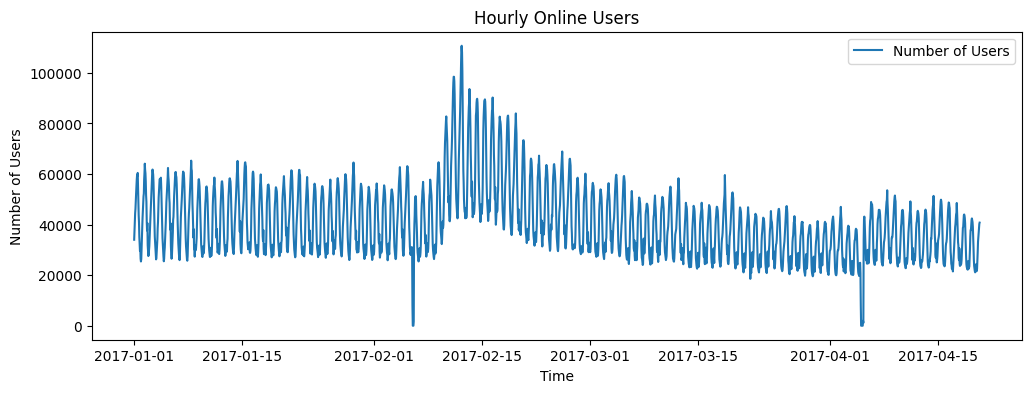

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Users'], label='Number of Users')
plt.xlabel('Time')
plt.ylabel('Number of Users')
plt.title('Hourly Online Users')
plt.legend()
plt.show()

### Построив график с амплитудой активности пользователей по времени - заметна цикличность данных.
### Цикличность временного ряда - колебания временного ряда, которые происходят на более длительных временных интервалах и не обязательно регулярны.

### Проведем проверку на стационарность

In [4]:
adf_test_all = adfuller(data['Users'])
 
print('ADF Test:')
print(f'ADF Statistic: {adf_test_all[0]}')
print(f'p-value = {adf_test_all[1]}')
if adf_test_all[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')
print(f'Critical Values:')
for key, value in adf_test_all[4].items():
    print(f'   {key}: {value}')

ADF Test:
ADF Statistic: -2.245379032136136
p-value = 0.19018943960897805
Ряд не стационарен
Critical Values:
   1%: -3.43286857268081
   5%: -2.8626527106640043
   10%: -2.567362335821588


### Вычислим скользящее среднее, для этого используем метод rolling() из pandas, который создает окно и вычисляет среднее значение элементов внутри этого окна

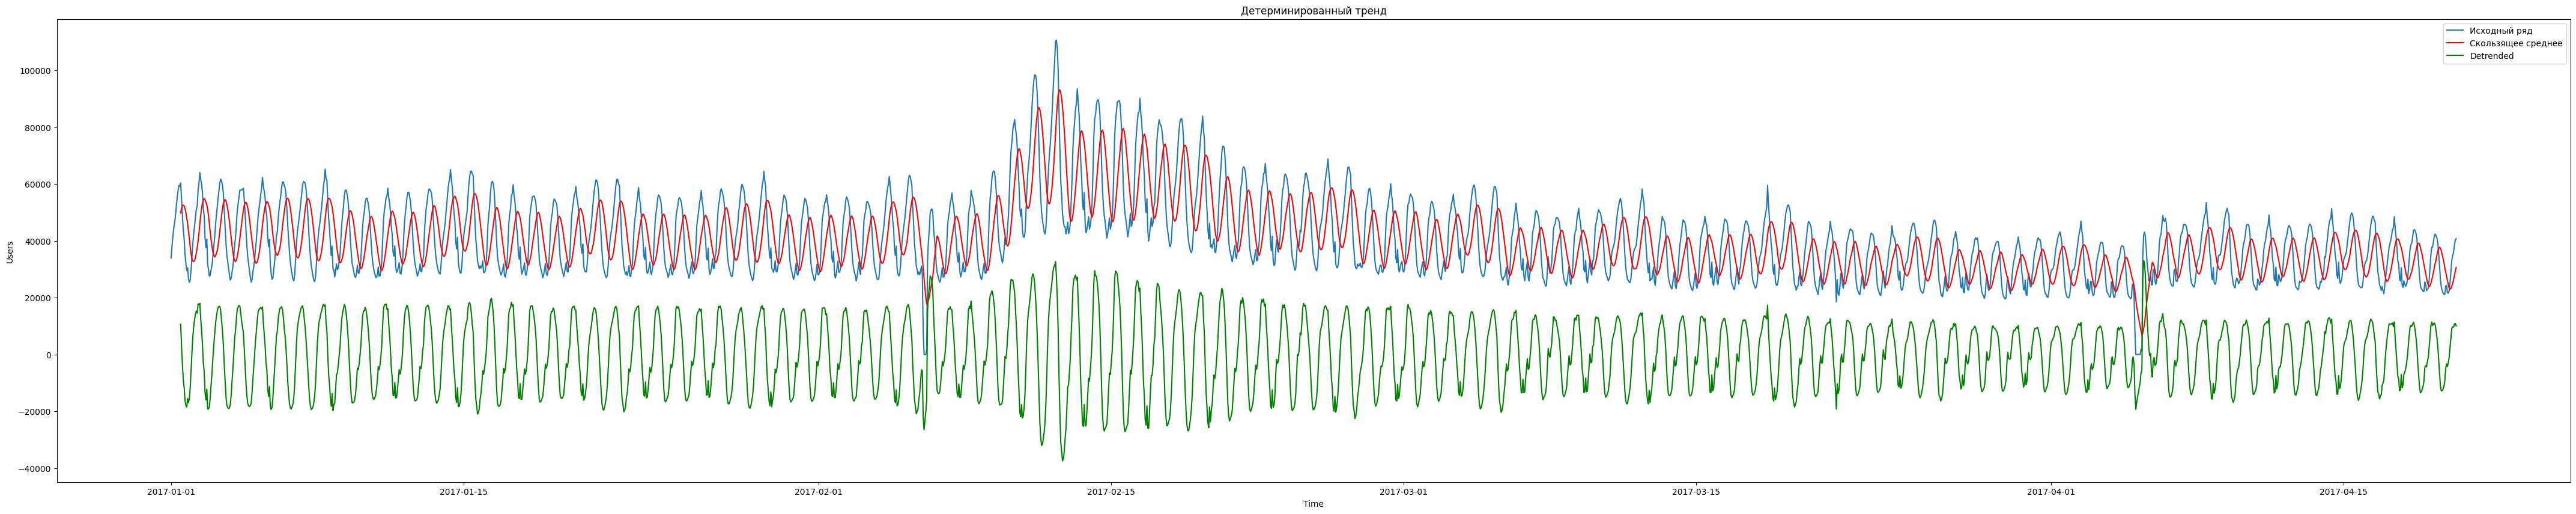

In [5]:
# Установим окно равное 12
rolling_mean = data['Users'].rolling(window=12).mean()

# Детерминируем тренд
detrended = data['Users'] - rolling_mean

plt.figure(figsize=(54, 10))
plt.plot(data['Users'], label='Исходный ряд')
plt.plot(rolling_mean, label='Скользящее среднее', color='red')
plt.plot(detrended, label='Detrended', color='green')
plt.title('Детерминированный тренд')
plt.xlabel('Time')
plt.ylabel('Users')
plt.grid(False) 
plt.legend()
plt.show()

### Посмотрим на график рассеивания с временным лагом в один день.
### Для создания признака с лагом временного ряда мы смещаем наблюдения целевого признака таким образом, чтобы они выглядели как произошедшие позже во времени. 

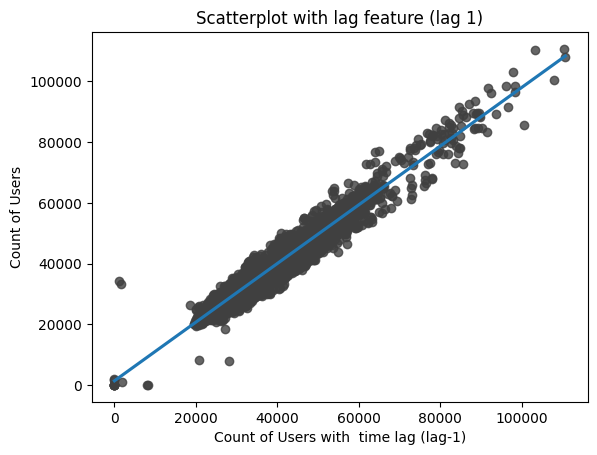

In [6]:
data.dropna(inplace=True)
data['lag_1'] = data['Users'].shift(1)

fig, ax = plt.subplots() 
ax = sns.regplot(x='lag_1', y='Users', data=data, ci=None, scatter_kws=dict(color='0.25'))

# Устанавливаем заголовок и подписи осей
ax.set_title('Scatterplot with lag feature (lag 1)')
ax.set_xlabel('Count of Users with  time lag (lag-1)')
ax.set_ylabel('Count of Users')

plt.show()

### Из точечного графика видно, что количество пользователей в один день сильно коррелируют с количеством пользователей за предыдущий день.

### Построим декомпозицию временного ряда на компоненты: тренд, сезонность и остатки

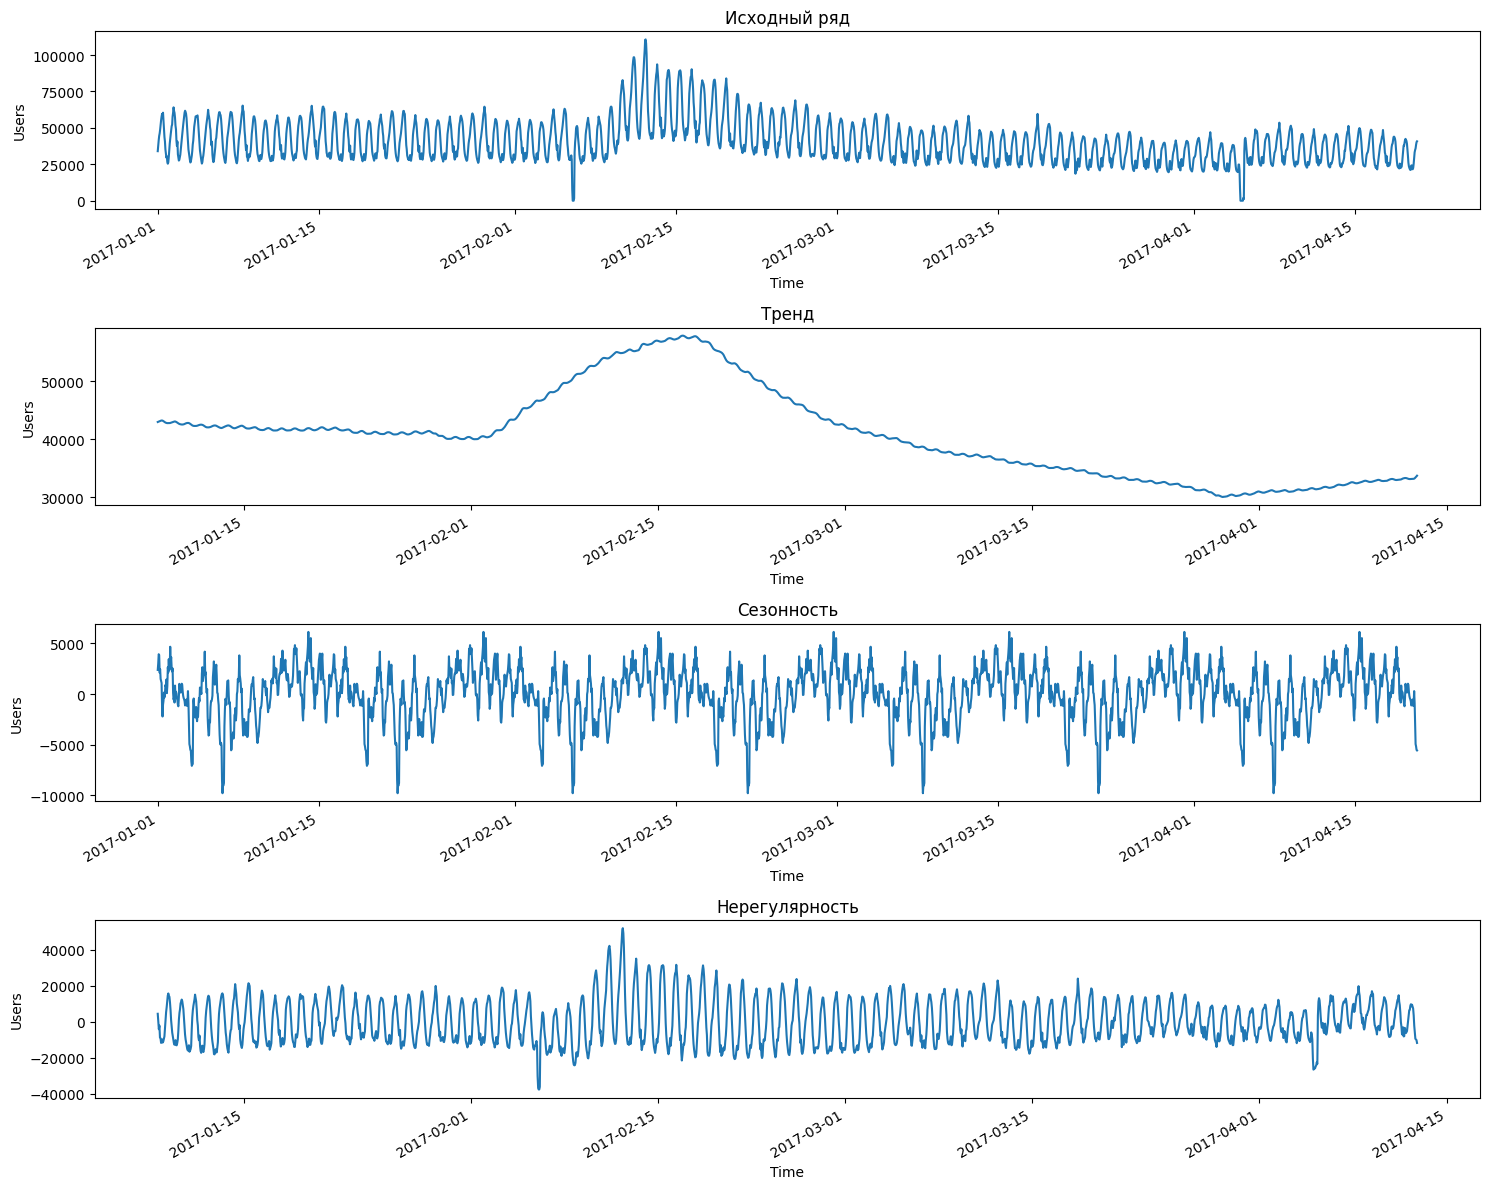

In [7]:
import statsmodels.api as sm

data_second = pd.read_csv('/Users/dianashilova/Desktop/TMSds_all/lesson40/hour_online.csv', parse_dates=True)

# Делаем дату индексом
data_second.set_index('Time', inplace=True)

# Декомпозиция временного ряда
decomposition = sm.tsa.seasonal_decompose(data['Users'], model='additive', period=365)

# Визуализация компонентов временного ряда
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Исходный ряд
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Users')
ax1.set_title('Исходный ряд')

# Тренд
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Users')
ax2.set_title('Тренд')

# Сезонность
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Users')
ax3.set_title('Сезонность')

# Остатки
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Users')
ax4.set_title('Нерегулярность')

plt.tight_layout()
plt.show()

### Автокорреляция — это мера корреляции между временным рядом и его лагированными (отстающими) значениями. Это позволяет нам определить зависимость текущих значений  от предыдущих.

### Частичная автокорреляция — это мера корреляции между временным рядом и его лагированными значениями с учетом корреляции в промежуточных лагах. Она помогает выявить «чистую» зависимость от определенных отстающих значений, исключая влияние промежуточных лагов.

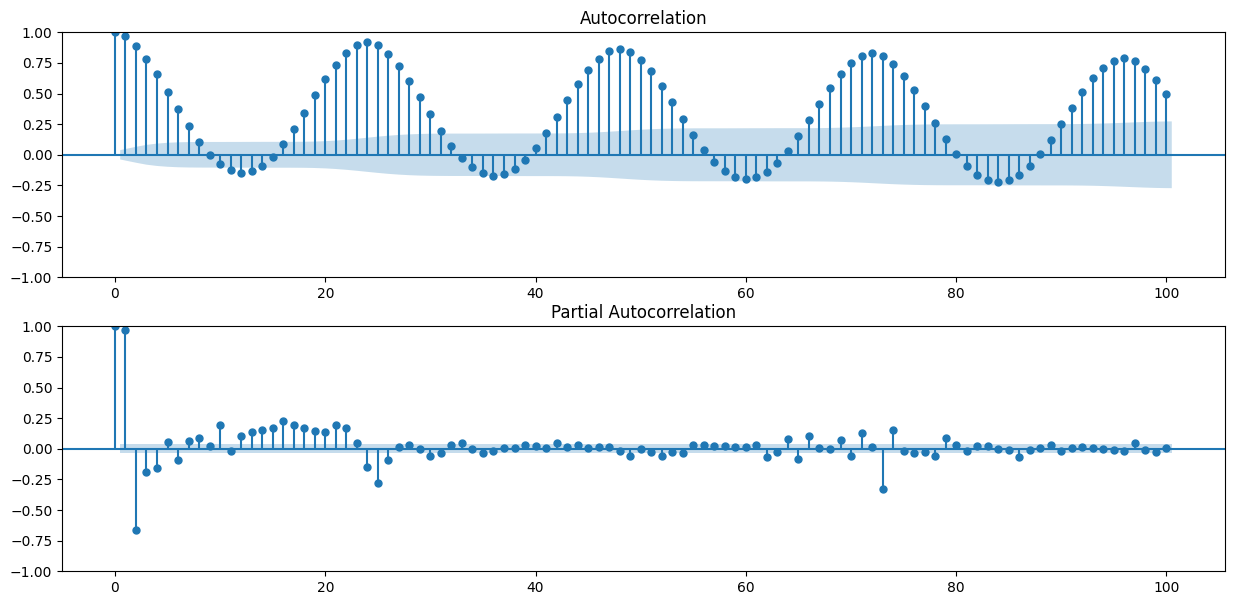

In [8]:
fig, ax = plt.subplots(2, figsize=(15, 7))
ax[0] = plot_acf(data.Users, ax=ax[0], lags=100)
ax[1] = plot_pacf(data.Users, ax=ax[1], lags=100)

### Выводы и подбор параметров:

#### Параметры AR (p): На PACF-графике значимые пики на первых нескольких лагах (например, 1 и 5), что может указывать на AR-компоненты. Параметр p может быть около 5 или 10.
#### Параметры MA (q):  На ACF-графике видны значительные пики на нескольких лагах, что указывает на наличие MA-компоненты. Параметр q может быть около 5 или 10.
#### Сезонность: Значительные пики на ACF и PACF на интервалах около 5 лагов указывают на сезонность в данных. Это можно учитывать в модели ARIMA, добавив сезонные параметры.

### Для дифференцирования воспользуемся методом diff(), который вычисляет разность между текущим значением временного ряда и предыдущим значением. Это позволяет получить ряд первых разностей, который отражает изменения значений во времени.

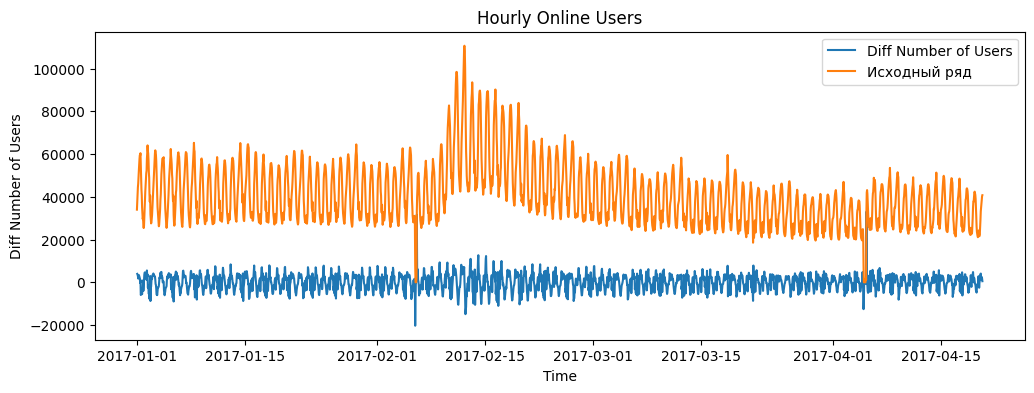

In [9]:
diff_series = data['Users'].diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(diff_series, label='Diff Number of Users')
plt.plot(data['Users'], label='Исходный ряд')
plt.ylabel('Diff Number of Users')
plt.xlabel('Time')
plt.title('Hourly Online Users')
plt.legend()
plt.show()

### Модель ARIMA способна адаптировать ряд к стационарности «самостоятельно», за это свойство ответственен специальный параметр модели (d).

 Модель ARIMA обычно обозначается как ARIMA (p, d, q), где p, d и q — параметры модели: 

p — порядок авторегрессии, который описывает количество предыдущих наблюдений, принимаемых во внимание в модели.   
d — порядок интегрирования, который указывает, сколько раз нужно взять разность временного ряда для достижения стационарности.   
q — порядок скользящего среднего, который связан с количеством предыдущих ошибок, используемых в модели.

#### Попробуем сделать прогноз без преобразования данных

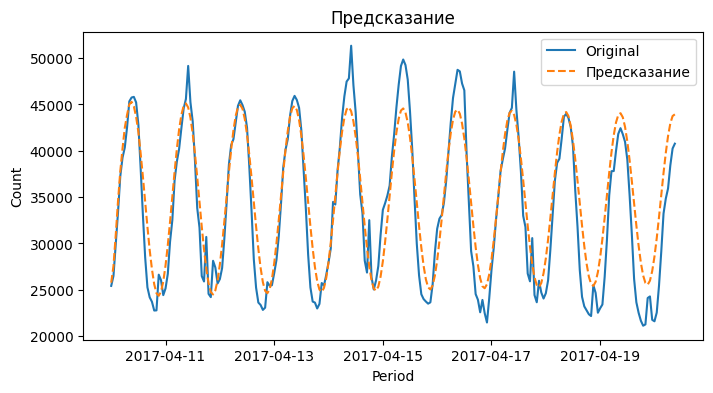

In [13]:
data = pd.read_csv('/Users/dianashilova/Desktop/TMSds_all/lesson40/hour_online.csv', index_col='Time', parse_dates=True)

start_date = '2017-04-10'
train_f_arima = data[data['Users'].index < start_date]
test_f_arima = data[data.index >= start_date]

model = ARIMA(train_f_arima['Users'], order=(6, 1, 10))
model_fit = model.fit()

forecast = model_fit.forecast(steps=250)

mae_f_arima = mean_absolute_error(test_f_arima[:250], forecast)

plt.figure(figsize=(8, 4))
plt.plot(test_f_arima.index, test_f_arima, label='Original')
plt.plot(test_f_arima.index, forecast, label='Предсказание', linestyle='--')
plt.xlabel('Period')
plt.ylabel('Count')
plt.title('Предсказание')
plt.legend()
plt.show()

#### Видно, что цикличность сохраняется на прогнозе, но недостаточно точно расчитываются пики и провалы. Попробуем провести прогнозирование на дифферинцированном ряде

MAE in the first dataset: 1110.3126709490323


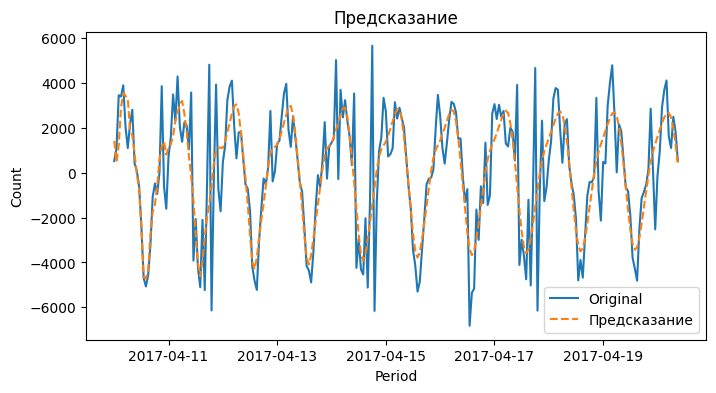

In [14]:
diff_series = data.diff().dropna()
train_arima = diff_series[diff_series.index < start_date] #главная выборка
test_arima = diff_series[diff_series.index >= start_date]

model = ARIMA(train_arima['Users'], order=(30, 0, 30))
model_fit = model.fit()

forecast = model_fit.forecast(steps=250)

mae = mean_absolute_error(test_arima.Users, forecast)
print(f'MAE in the first dataset: {mae}')

plt.figure(figsize=(8, 4))
plt.plot(test_arima.index, test_arima, label='Original')
plt.plot(test_arima.index, forecast, label='Предсказание', linestyle='--')
plt.xlabel('Period')
plt.ylabel('Count')
plt.title('Предсказание')
plt.legend()
plt.show()

## Как оценить ошибку???

### Проведем логарифмирование данных с заменой выбросов по медианному значению и сделаем дифференцирование ряда

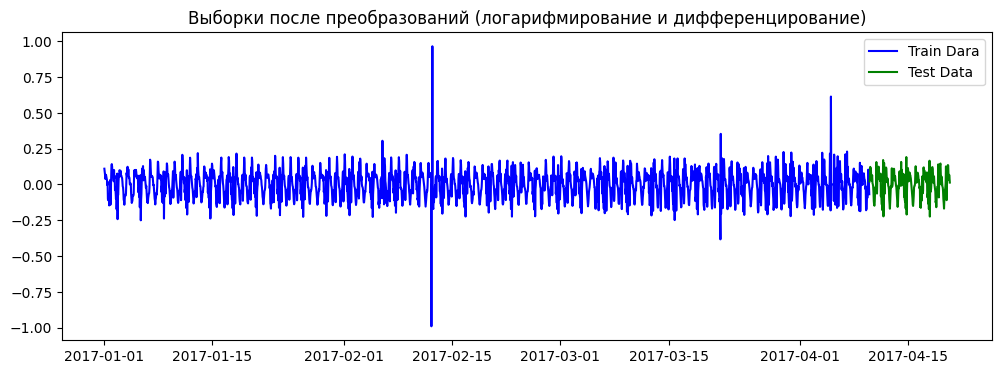

In [15]:
data_log = np.log(data['Users'])
mid_date = '2017-04-10'

start_date = '2017-04-10'
train_f = data[data.index < start_date] #главная выборкал
test_f = data[data.index >= start_date]

Q1 = data_log.quantile(0.25)
Q3 = data_log.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_log[(data_log < lower_bound) | (data_log > upper_bound)]
median_value = data_log.median()
data_log[outliers.index] = median_value

data_all_log_diff = data_log.diff().dropna()
train_f_log_diff = data_all_log_diff[data_all_log_diff.index < mid_date]
test_f_log_diff = data_all_log_diff[data_all_log_diff.index >= mid_date]

train_f_log = data_log[data_log.index < mid_date]

plt.figure(figsize=(12, 4))
plt.plot(train_f_log_diff.index, train_f_log_diff, label='Train Dara', color='b')
plt.plot(test_f_log_diff.index, test_f_log_diff, label='Test Data', color='g')
plt.title('Выборки после преобразований (логарифмирование и дифференцирование)')
plt.legend()
plt.show()

### Проверка стационарности ряда с учетом преобразования

In [16]:
adf_test_all = adfuller(data_all_log_diff)
 
print('ADF Test:')
print(f'ADF Statistic: {adf_test_all[0]}')
print(f'p-value = {adf_test_all[1]}')
if adf_test_all[1] < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')
print(f'Critical Values:')
for key, value in adf_test_all[4].items():
    print(f'   {key}: {value}')

ADF Test:
ADF Statistic: -12.266244025436274
p-value = 8.847024101685838e-23
Ряд стационарен
Critical Values:
   1%: -3.4328724587241686
   5%: -2.862654426799674
   10%: -2.567363249505311


### Проведем ряд небольших прогнозов для кросс валидации

Holt-Winters MAE: 2779.1969067524037


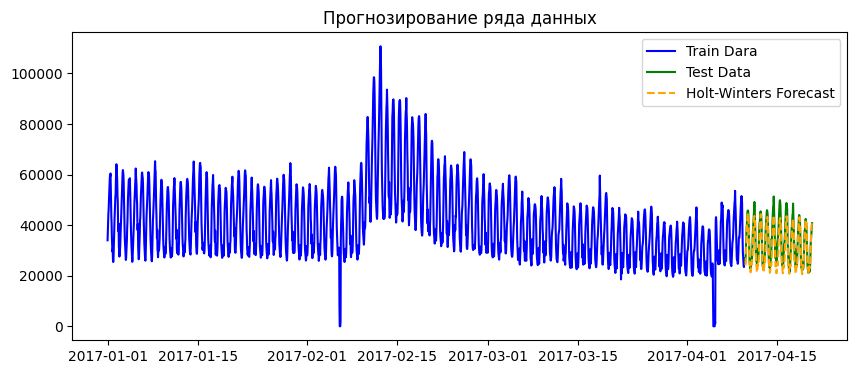

In [17]:
data_log = np.log(data['Users'])
mid_date = '2017-04-10'

start_date = '2017-04-10'
train_f = data[data.index < start_date] #главная выборкал
test_f = data[data.index >= start_date]

model_holt = ExponentialSmoothing(train_f_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=48).fit()

forecast_holt_diff = model_holt.forecast(steps=len(test_f_log_diff))

forecast_holt_log = train_f_log[-1] + forecast_holt_diff.cumsum()
forecast_holt = np.exp(forecast_holt_log)
test_f_log_restored = train_f_log[-1] + test_f_log_diff.cumsum()
test_f_restored = np.exp(test_f_log_restored)

mae_holt = mean_absolute_error(test_f.Users, forecast_holt)
print(f'Holt-Winters MAE: {mae_holt}')

plt.figure(figsize=(10, 4))
plt.plot(train_f.index, train_f, label='Train Dara', color='b')
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.title('Прогнозирование ряда данных')
plt.legend()
plt.show()

Holt-Winters MAE: 1686.9506846090137


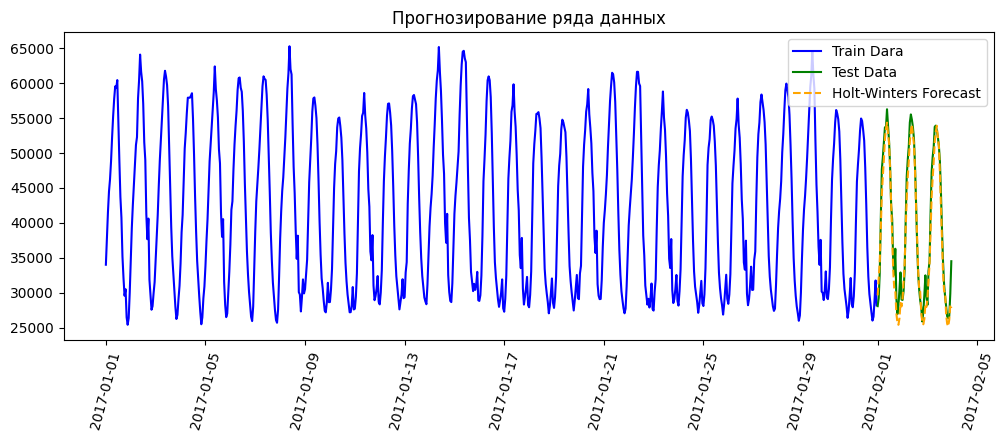

In [18]:
data_2 = data[data.index < '2017-02-04']
data_log_2 = np.log(data_2['Users'])

mid_date_2 = '2017-02-01'
start_date = '2017-02-01'

train_2 = data_2[data_2.index < start_date] #главная выборкал
test_2 = data_2[data_2.index >= start_date]

Q1 = data_log_2.quantile(0.25)
Q3 = data_log_2.quantile(0.75)
IQR = Q3 - Q1

lower_bound_2 = Q1 - 1.5 * IQR
upper_bound_2 = Q3 + 1.5 * IQR

outliers_2 = data_log_2[(data_log_2 < lower_bound_2) | (data_log_2 > upper_bound_2)]
median_value_2 = data_log_2.median()
data_log_2[outliers_2.index] = median_value_2

data_all_log_diff_2 = data_log_2.diff().dropna()
train_2_log_diff = data_all_log_diff_2[data_all_log_diff_2.index < mid_date_2]
test_2_log_diff = data_all_log_diff_2[data_all_log_diff_2.index >= mid_date_2]

train_2_log = data_log_2[data_log_2.index < mid_date_2]


model_holt_2 = ExponentialSmoothing(train_2_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=48).fit()

forecast_holt_diff_2 = model_holt_2.forecast(steps=len(test_2_log_diff))

forecast_holt_log_2 = train_2_log[-1] + forecast_holt_diff_2.cumsum()
forecast_holt_2 = np.exp(forecast_holt_log_2)
test_2_log_restored = train_2_log[-1] + test_2_log_diff.cumsum()
test_2_restored = np.exp(test_2_log_restored)

mae_holt_2 = mean_absolute_error(test_2, forecast_holt_2)
print(f'Holt-Winters MAE: {mae_holt_2}')

plt.figure(figsize=(12, 4))
plt.plot(train_2.index, train_2, label='Train Dara', color='b')
plt.plot(test_2.index, test_2, label='Test Data', color='g')
plt.plot(test_2.index, forecast_holt_2, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.title('Прогнозирование ряда данных')
plt.xticks(rotation=75)
plt.legend()
plt.show()

Holt-Winters MAE: 8747.671382734005


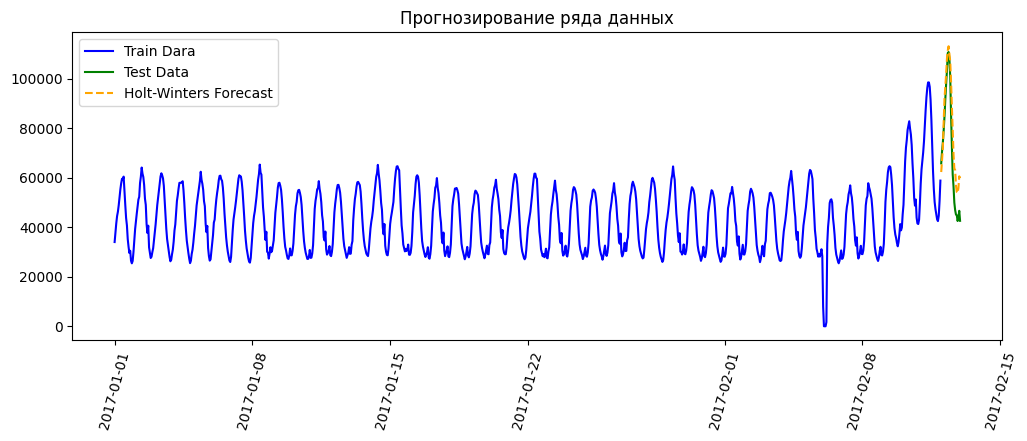

In [19]:
data_3 = data[data.index < '2017-02-13']
data_log_3 = np.log(data_3['Users'])

mid_date_3 = '2017-02-12'
start_date = '2017-02-12'

train_3 = data_3[data_3.index < start_date] #главная выборкал
test_3 = data_3[data_3.index >= start_date]

Q1 = data_log_3.quantile(0.25)
Q3 = data_log_3.quantile(0.75)
IQR = Q3 - Q1

lower_bound_3 = Q1 - 1.5 * IQR
upper_bound_3 = Q3 + 1.5 * IQR

outliers_3 = data_log_3[(data_log_3 < lower_bound_3) | (data_log_3 > upper_bound_3)]
median_value_3 = data_log_3.median()
data_log_3[outliers_3.index] = median_value_3

data_all_log_diff_3 = data_log_3.diff().dropna()
train_3_log_diff = data_all_log_diff_3[data_all_log_diff_3.index < mid_date_3]
test_3_log_diff = data_all_log_diff_3[data_all_log_diff_3.index >= mid_date_3]

train_3_log = data_log_3[data_log_3.index < mid_date_3]


model_holt_3 = ExponentialSmoothing(train_3_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=48).fit()

forecast_holt_diff_3 = model_holt_3.forecast(steps=len(test_3_log_diff))

forecast_holt_log_3 = train_3_log[-1] + forecast_holt_diff_3.cumsum()
forecast_holt_3 = np.exp(forecast_holt_log_3)
test_3_log_restored = train_3_log[-1] + test_3_log_diff.cumsum()
test_3_restored = np.exp(test_3_log_restored)

mae_holt_3 = mean_absolute_error(test_3, forecast_holt_3)
print(f'Holt-Winters MAE: {mae_holt_3}')

plt.figure(figsize=(12, 4))
plt.plot(train_3.index, train_3, label='Train Dara', color='b')
plt.plot(test_3.index, test_3, label='Test Data', color='g')
plt.plot(test_3.index, forecast_holt_3, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.title('Прогнозирование ряда данных')
plt.xticks(rotation=75)
plt.legend()
plt.show()

Holt-Winters MAE: 5018.1078920623595


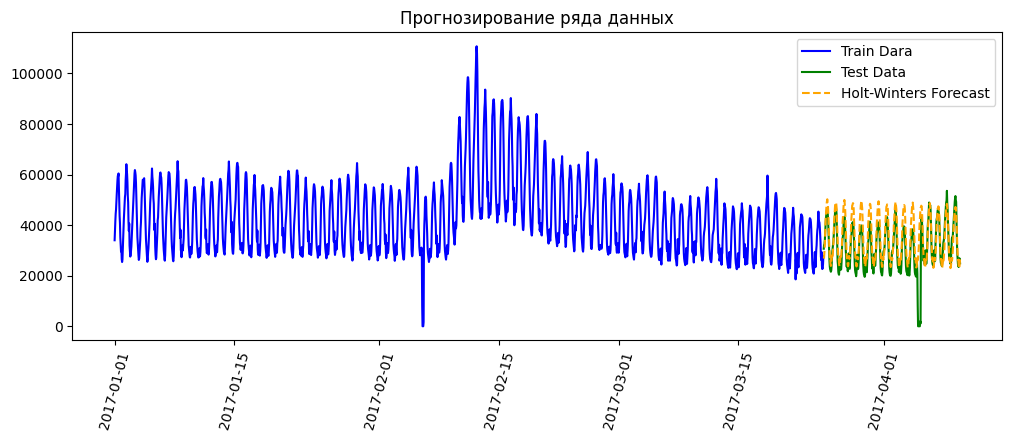

In [20]:
data_4 = data[data.index < '2017-04-10']
data_log_4 = np.log(data_4['Users'])

mid_date_4 = '2017-03-25'
start_date = '2017-03-25'

train_4 = data_4[data_4.index < start_date] #главная выборкал
test_4 = data_4[data_4.index >= start_date]

Q1 = data_log_4.quantile(0.25)
Q3 = data_log_4.quantile(0.75)
IQR = Q3 - Q1

lower_bound_4 = Q1 - 1.5 * IQR
upper_bound_4 = Q3 + 1.5 * IQR

outliers_4 = data_log_4[(data_log_4 < lower_bound_4) | (data_log_4 > upper_bound_4)]
median_value_4 = data_log_4.median()
data_log_4[outliers_4.index] = median_value_4

data_all_log_diff_4 = data_log_4.diff().dropna()
train_4_log_diff = data_all_log_diff_4[data_all_log_diff_4.index < mid_date_4]
test_4_log_diff = data_all_log_diff_4[data_all_log_diff_4.index >= mid_date_4]

train_4_log = data_log_4[data_log_4.index < mid_date_4]


model_holt_4 = ExponentialSmoothing(train_4_log_diff, damped_trend=True, trend='add', 
                                  initialization_method='estimated', seasonal='add', seasonal_periods=48).fit()

forecast_holt_diff_4 = model_holt_4.forecast(steps=len(test_4_log_diff))

forecast_holt_log_4 = train_4_log[-1] + forecast_holt_diff_4.cumsum()
forecast_holt_4 = np.exp(forecast_holt_log_4)
test_4_log_restored = train_4_log[-1] + test_4_log_diff.cumsum()
test_4_restored = np.exp(test_4_log_restored)

mae_holt_4 = mean_absolute_error(test_4.Users, forecast_holt_4)
print(f'Holt-Winters MAE: {mae_holt_4}')

plt.figure(figsize=(12, 4))
plt.plot(train_4.index, train_4, label='Train Dara', color='b')
plt.plot(test_4.index, test_4, label='Test Data', color='g')
plt.plot(test_4.index, forecast_holt_4, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.title('Прогнозирование ряда данных')
plt.xticks(rotation=75)
plt.legend()
plt.show()

### Итоги

In [21]:
results = pd.DataFrame(columns=['Period Train', 'Period Test', 'MAE Test', 'Description'])

results1 = {'Period Train': '2017-01-01 - 2017-04-09', 'Period Test': '2017-04-10 - 2017-04-17', 'MAE Test': round(mae_holt, 2), 'Description': 'Первичная выборка'}
results2 = {'Period Train': '2017-01-01 - 2017-01-31', 'Period Test': '2017-02-01 - 2017-02-04', 'MAE Test': round(mae_holt_2, 2), 'Description': 'Без колебаний'}
results3 = {'Period Train': '2017-01-01 - 2017-02-11', 'Period Test': '2017-02-12 - 2017-02-14', 'MAE Test': round(mae_holt_3, 2), 'Description': 'Скачок активности пользователей'}
results4 = {'Period Train': '2017-01-01 - 2017-03-24', 'Period Test': '2017-03-25 - 2017-04-10', 'MAE Test': round(mae_holt_4, 2), 'Description': 'Просадка активности пользователей'}
results5 = {'Period Train': '2017-01-01 - 2017-04-09', 'Period Test': '2017-04-10 - 2017-04-17', 'MAE Test': round(mae_f_arima, 2), 'Description': 'Первичная выборка без преобразования ряда по модели ARIMA'}
results = pd.concat([results, pd.DataFrame([results1, results5, results2, results3, results4])], ignore_index=True)

results

,Period Train,Period Test,MAE Test,Description
0,2017-01-01 - 2017-04-09,2017-04-10 - 2017-04-17,2779.20,Первичная выборка
1,2017-01-01 - 2017-04-09,2017-04-10 - 2017-04-17,2610.65,Первичная выборка без преобразования ряда по м...
2,2017-01-01 - 2017-01-31,2017-02-01 - 2017-02-04,1686.95,Без колебаний
3,2017-01-01 - 2017-02-11,2017-02-12 - 2017-02-14,8747.67,Скачок активности пользователей
4,2017-01-01 - 2017-03-24,2017-03-25 - 2017-04-10,5018.11,Просадка активности пользователей


Text(0.5, 1.0, 'Гистограмма значений выборки 4')

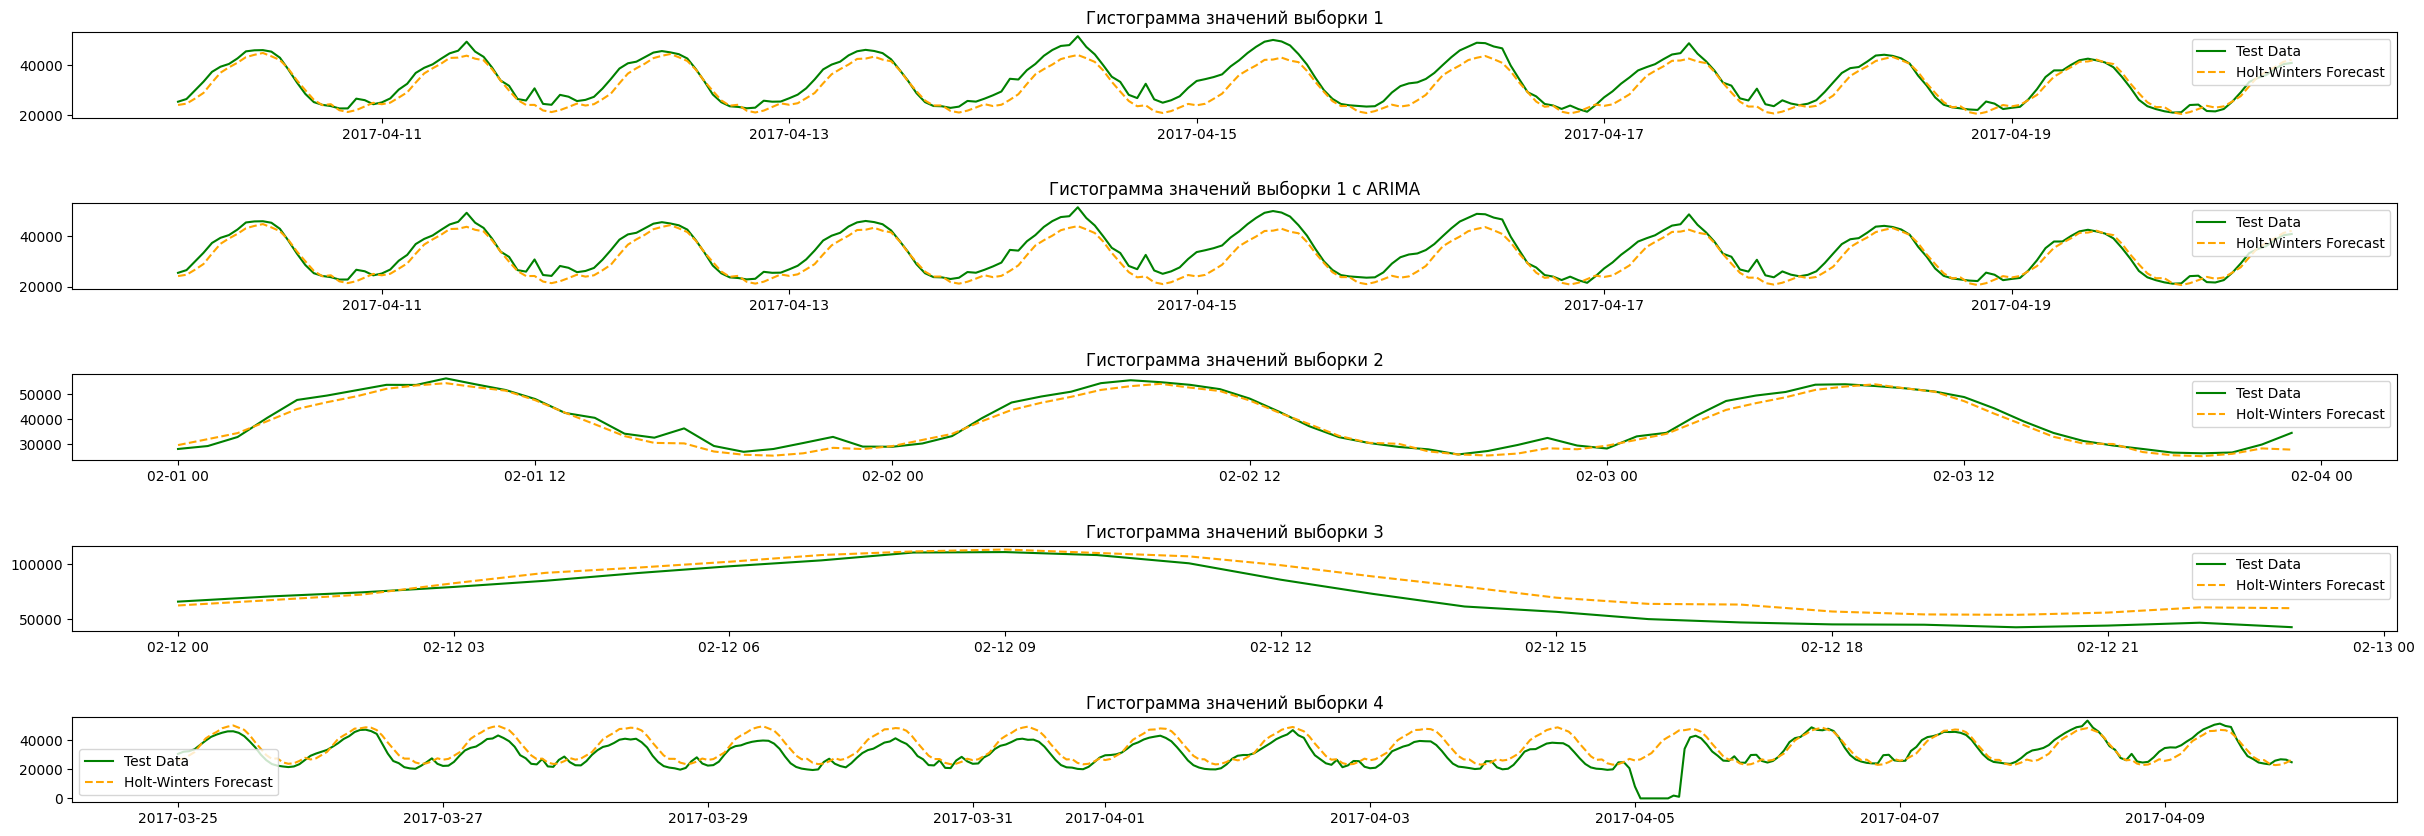

In [24]:
plt.figure(figsize=(30, 10))
plt.subplots_adjust(hspace=1)

plt.subplot(5, 1, 1)
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title ("Гистограмма значений выборки 1")

plt.subplot(5, 1, 2)
plt.plot(test_f.index, test_f, label='Test Data', color='g')
plt.plot(test_f.index, forecast_holt, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title ("Гистограмма значений выборки 1 c ARIMA")

plt.subplot(5, 1, 3)
plt.plot(test_2.index, test_2, label='Test Data', color='g')
plt.plot(test_2.index, forecast_holt_2, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title ("Гистограмма значений выборки 2")

plt.subplot(5, 1, 4)
plt.plot(test_3.index, test_3, label='Test Data', color='g')
plt.plot(test_3.index, forecast_holt_3, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title ("Гистограмма значений выборки 3")

plt.subplot(5, 1, 5)
plt.plot(test_4.index, test_4, label='Test Data', color='g')
plt.plot(test_4.index, forecast_holt_4, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.legend()
plt.title ("Гистограмма значений выборки 4")